# Jakub Grzyb, GGSN 2025, grupa 1
# Social Anxiety Dataset
https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, recall_score, precision_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, roc_auc_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import product

2025-03-29 00:18:37.413975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743203917.442085  467225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743203917.448578  467225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743203917.464460  467225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743203917.464491  467225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743203917.464494  467225 computation_placer.cc:177] computation placer alr

# Dataset

In [2]:
import requests
import zipfile
import io
import os

url = "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extract("data.csv")
        os.rename("data.csv", "student_dropout.csv")
else:
    print("Failed to download the file.")

# Helper functions

In [3]:
def get_metrics(data: list):
    tmp = pd.DataFrame(columns=[d[0] for d in data], index=[
                       'accuracy', 'f1', 'recall', 'precision'])
    for i, d in enumerate(data):
        tmp.iloc[0, i] = accuracy_score(d[1], d[2], normalize=True)
        tmp.iloc[1, i] = f1_score(d[1], d[2], average='weighted')
        tmp.iloc[2, i] = recall_score(d[1], d[2], average='weighted')
        tmp.iloc[3, i] = precision_score(d[1], d[2], average='weighted')
    return tmp.T

In [4]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
def plot_bar_params(params: list, scores: list, title: str):
    train_scores = [s[0] for s in scores]
    val_scores = [s[1] for s in scores]

    x_labels = [f"{params[i]}" for i in range(len(scores))]
    x = np.arange(len(scores))

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35

    ax.bar(x - bar_width/2, train_scores, bar_width,
           label='Train Scores', color='green')
    ax.bar(x + bar_width/2, val_scores, bar_width,
           label='Validation Scores', color='blue')

    ax.set_xlabel('Configurations')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.legend()

    # Adjust the y-axis lower limit to cut the lower part of the chart
    ax.set_ylim(bottom=min(min(train_scores), min(val_scores)) - 0.02)

    plt.tight_layout()
    plt.show()

In [6]:
def plot_multi_history(histories, params, title):
    # Create a 2x2 grid for the plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Plot training accuracy
    for i, history in enumerate(histories):
        axes[0, 0].plot(history.history['accuracy'],
                        label=f'Train Accuracy {params[i]}')
    axes[0, 0].set_title(f'{title} - Training Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    # Plot validation accuracy
    for i, history in enumerate(histories):
        axes[0, 1].plot(history.history['val_accuracy'],
                        label=f'Validation Accuracy {params[i]}')
    axes[0, 1].set_title(f'{title} - Validation Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot training loss
    for i, history in enumerate(histories):
        axes[1, 0].plot(history.history['loss'],
                        label=f'Train Loss {params[i]}')
    axes[1, 0].set_title(f'{title} - Training Loss')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    # Plot validation loss
    for i, history in enumerate(histories):
        axes[1, 1].plot(history.history['val_loss'],
                        label=f'Validation Loss {params[i]}')
    axes[1, 1].set_title(f'{title} - Validation Loss')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create the plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add colorbar
    plt.colorbar(im)

    # Add labels and title
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Easiest aproach

In [8]:
df = pd.read_csv('student_dropout.csv', sep=';')
df

Marital status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance\t  Previous qualification  \
0                                1                       1   
1                                1                       1   
2                                1                       1   
3                                1                       1   
4                                0                       1   
...                            ...                     ...   
4419                             1                       1   
4420                             1                       1   
4421                             1                       1   
4422                             1                       1   
4423                             1                       1   

      Previous qualification (grade)  Nacionality  Mother's qualification  \
0                              122.0            1                      19   
1                              160.0            1                       1   
2                              122.0            1                      37   
3                              122.0            1                      38   
4                              100.0            1                      37   
...                              ...          ...                     ...   
4419                           125.0            1                       1   
4420                           120.0          105                       1   
4421                           154.0            1                      37   
4422                           180.0            1                      37   
4423                           152.0           22                      38   

      Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                         12  ...                                    0   
1                          3  ...                                    0   
2                         37  ...                                    0   
3                         37  ...                                    0   
4                         38  ...                                    0   
...                      ...  ...                                  ...   
4419                       1  ...                                    0   
4420                       1  ...                                    0   
4421                      37  ...                                    0   
4422                      37  ...                                    0   
4423                      37  ...                                    0   

      Curricular units 2nd sem (enrolled)  \
0                                       0   
1                                       6   
2                                       6   
3                                       6   
4                                       6   
...                                   ...   
4419                                    6   
4420                                    6   
4421                                    8   
4422                                    5   
4423                                    6   

      Curricular units 2nd sem (evaluations)  \
0                            

In [9]:
X = df.drop('Target', axis=1)
Y = df['Target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 2})

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

       accuracy        f1    recall precision
train  0.751696  0.747729  0.751696  0.757684
test   0.741243  0.739551  0.741243  0.747162


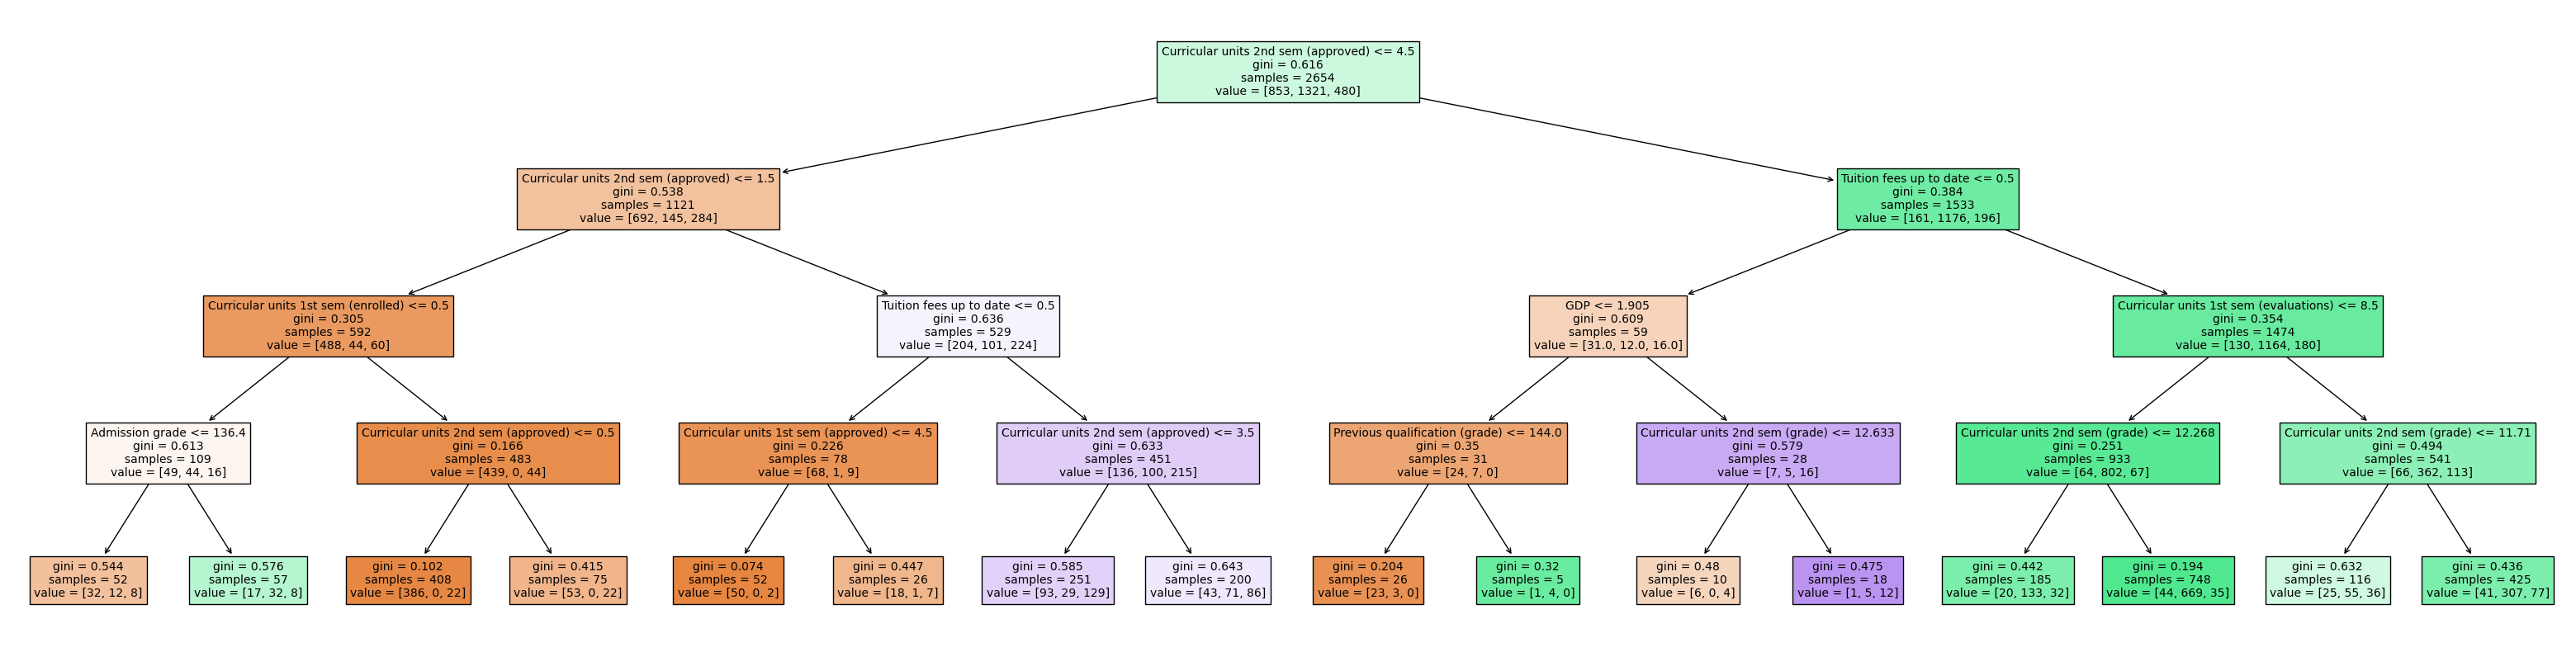

In [10]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

m = get_metrics([
    ('train', Y_train, Y_train_pred),
    ('test', Y_test, Y_test_pred)
])
print(m)

fig, ax = plt.subplots(1, 1, figsize=(40, 10))
plot_tree(model, filled=True, ax=ax, feature_names=X.columns, fontsize=10)
plt.show()

# Data processing

## Read data

In [11]:
df = pd.read_csv('student_dropout.csv', sep=';')
df

Marital status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance\t  Previous qualification  \
0                                1                       1   
1                                1                       1   
2                                1                       1   
3                                1                       1   
4                                0                       1   
...                            ...                     ...   
4419                             1                       1   
4420                             1                       1   
4421                             1                       1   
4422                             1                       1   
4423                             1                       1   

      Previous qualification (grade)  Nacionality  Mother's qualification  \
0                              122.0            1                      19   
1                              160.0            1                       1   
2                              122.0            1                      37   
3                              122.0            1                      38   
4                              100.0            1                      37   
...                              ...          ...                     ...   
4419                           125.0            1                       1   
4420                           120.0          105                       1   
4421                           154.0            1                      37   
4422                           180.0            1                      37   
4423                           152.0           22                      38   

      Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                         12  ...                                    0   
1                          3  ...                                    0   
2                         37  ...                                    0   
3                         37  ...                                    0   
4                         38  ...                                    0   
...                      ...  ...                                  ...   
4419                       1  ...                                    0   
4420                       1  ...                                    0   
4421                      37  ...                                    0   
4422                      37  ...                                    0   
4423                      37  ...                                    0   

      Curricular units 2nd sem (enrolled)  \
0                                       0   
1                                       6   
2                                       6   
3                                       6   
4                                       6   
...                                   ...   
4419                                    6   
4420                                    6   
4421                                    8   
4422                                    5   
4423                                    6   

      Curricular units 2nd sem (evaluations)  \
0                            

## Visualization and distribution

/home/jakub/miniconda3/envs/tf_new/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


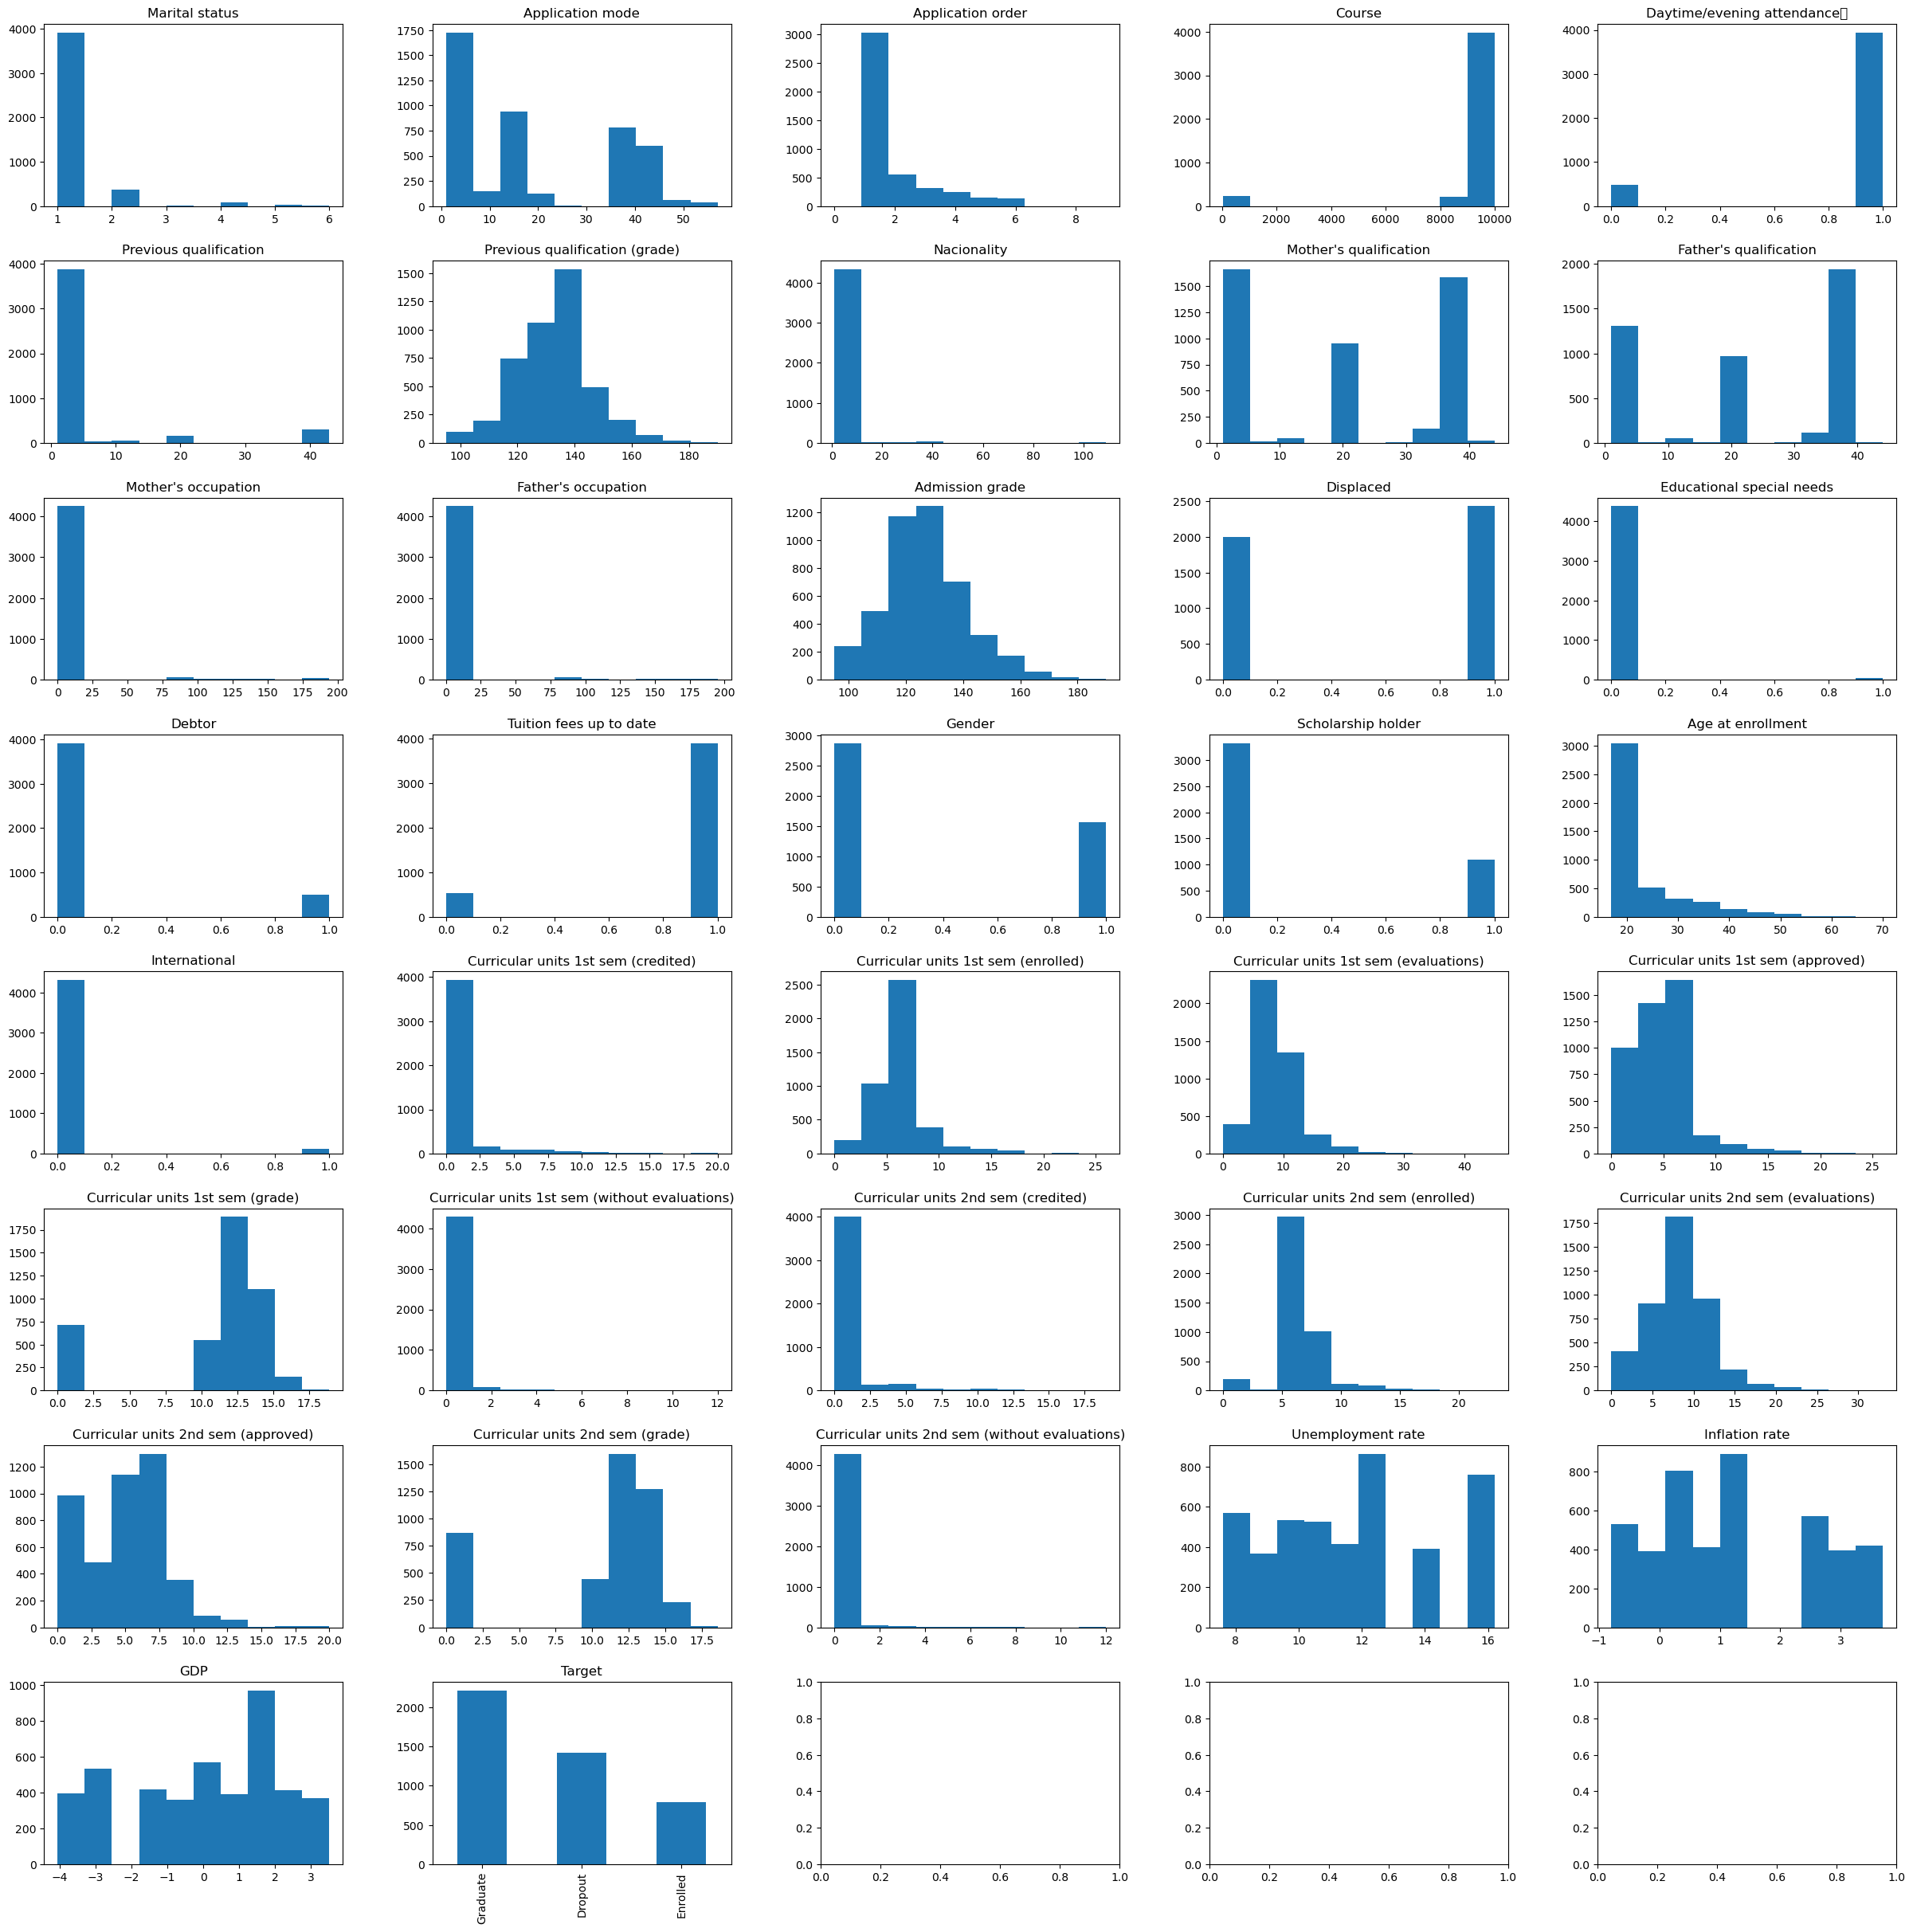

In [12]:
fig, ax = plt.subplots(8, 5, figsize=(30, 30), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
for i in range(df.columns.size):
    if df[df.columns[i]].dtype in [np.float64, np.int64]:
        df[df.columns[i]].plot(kind='hist', bins=10, ax=ax[i//5, i % 5], ylabel='', title=df.columns[i])
    else:
        df[df.columns[i]].value_counts().plot(kind='bar', ax=ax[i//5, i % 5], xlabel='', title=df.columns[i])

plt.show()

## Processing

In [13]:
def normalize(row):
    return (row - row.min()) / (row.max() - row.min())

def process_input(inp):
    dummy_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification',
                  'Previous qualification (grade)', 'Nacionality', 'Mother\'s qualification',
                  'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation']
    res = pd.DataFrame(inp)
    res = pd.get_dummies(res, columns=dummy_cols, prefix_sep=' ')
    
    for i in res:
        res[i] = normalize(res[i].astype(np.float64))
    return res

def process_output(Y: pd.Series):
    res = Y.copy()
    return res.map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 2})

In [14]:
df = pd.read_csv('student_dropout.csv', sep=';')
X = process_input(df.drop('Target', axis=1))
Y = process_output(df['Target'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

X_train: (3539, 347), X_test: (885, 347), Y_train: (3539,), Y_test: (885,)


# Models

### Decision Tree Classifier

       accuracy        f1    recall precision
train   0.75332  0.750541   0.75332  0.758015
test   0.724294  0.722048  0.724294  0.730534


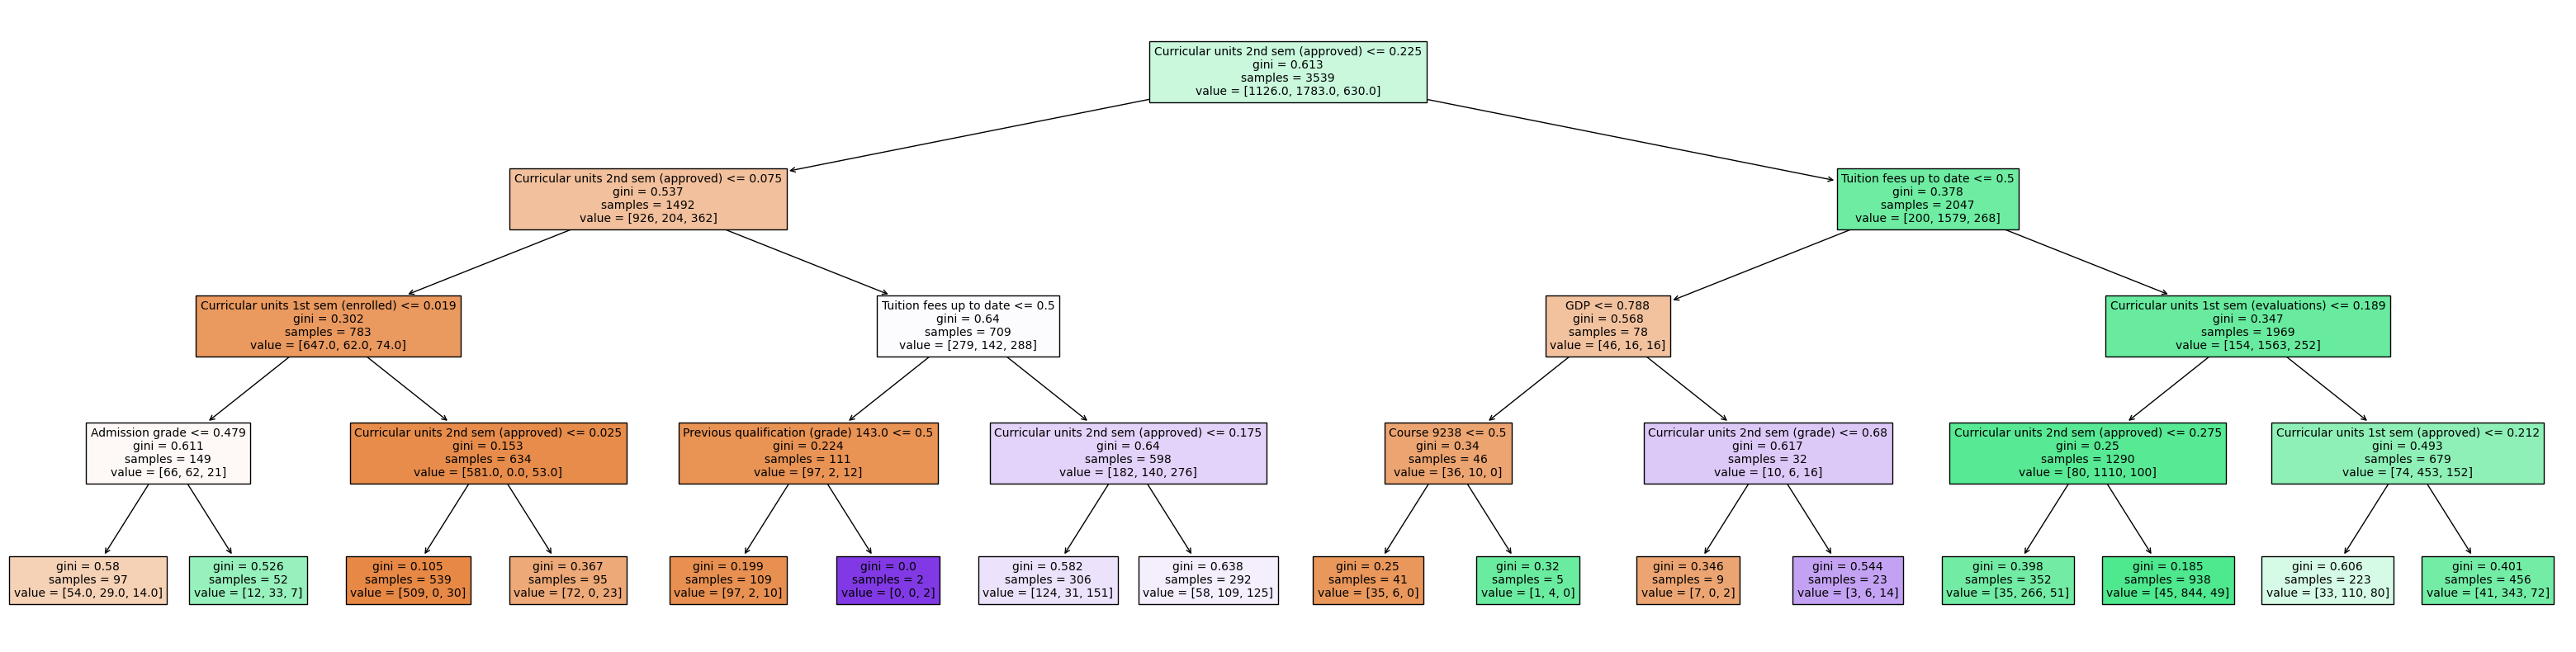

In [15]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print(get_metrics([
    ('train', Y_train, Y_train_pred),
    ('test', Y_test, Y_test_pred)
]))

fig, ax = plt.subplots(1, 1, figsize=(40, 10))
plot_tree(model, filled=True, ax=ax, feature_names=X.columns, fontsize=10)
plt.show()

### Random Forest Classifier

In [16]:
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print(get_metrics([
    ('train', Y_train, Y_train_pred),
    ('test', Y_test, Y_test_pred)
]))

       accuracy        f1    recall precision
train   0.73241  0.659564   0.73241  0.603853
test   0.716384  0.641586  0.716384  0.585833


/home/jakub/miniconda3/envs/tf_new/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jakub/miniconda3/envs/tf_new/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### XGBoost

In [17]:
model = XGBClassifier(n_estimators=100, max_depth=4)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print(get_metrics([
    ('train', Y_train, Y_train_pred),
    ('test', Y_test, Y_test_pred)
]))

       accuracy        f1    recall precision
train   0.92512   0.92372   0.92512  0.925584
test   0.759322  0.752209  0.759322  0.751165


### Tuning

Best params: (80, 3, 0.8)


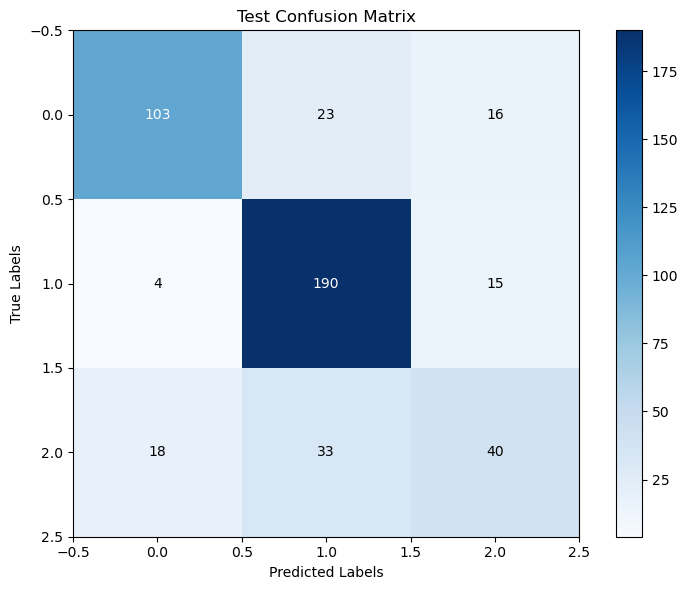

       accuracy        f1    recall precision
train  0.935575  0.934457  0.935575  0.935699
val    0.801354  0.794631  0.801354  0.793922
test   0.753394  0.744447  0.753394  0.745924


In [18]:
param_grid = {
    'n_estimators': [40, 60, 80, 100],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.6, 0.7, 0.8]
}

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

best_params = (None, None, None)
best_score = 0
best_model = None
for p in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']):
    model = XGBClassifier(
        n_estimators=p[0], max_depth=p[1], learning_rate=p[2])
    model.fit(X_train, Y_train)
    score = accuracy_score(Y_val, model.predict(X_val), normalize=True)
    if score > best_score:
        best_score = score
        best_params = p
        best_model = model

print(f'Best params: {best_params}')
model = best_model


Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
Y_val_pred = model.predict(X_val)

plot_confusion_matrix(Y_test, Y_test_pred, title="Test Confusion Matrix")

print(get_metrics([
    ('train', Y_train, Y_train_pred),
    ('val', Y_val, Y_val_pred),
    ('test', Y_test, Y_test_pred)
]))

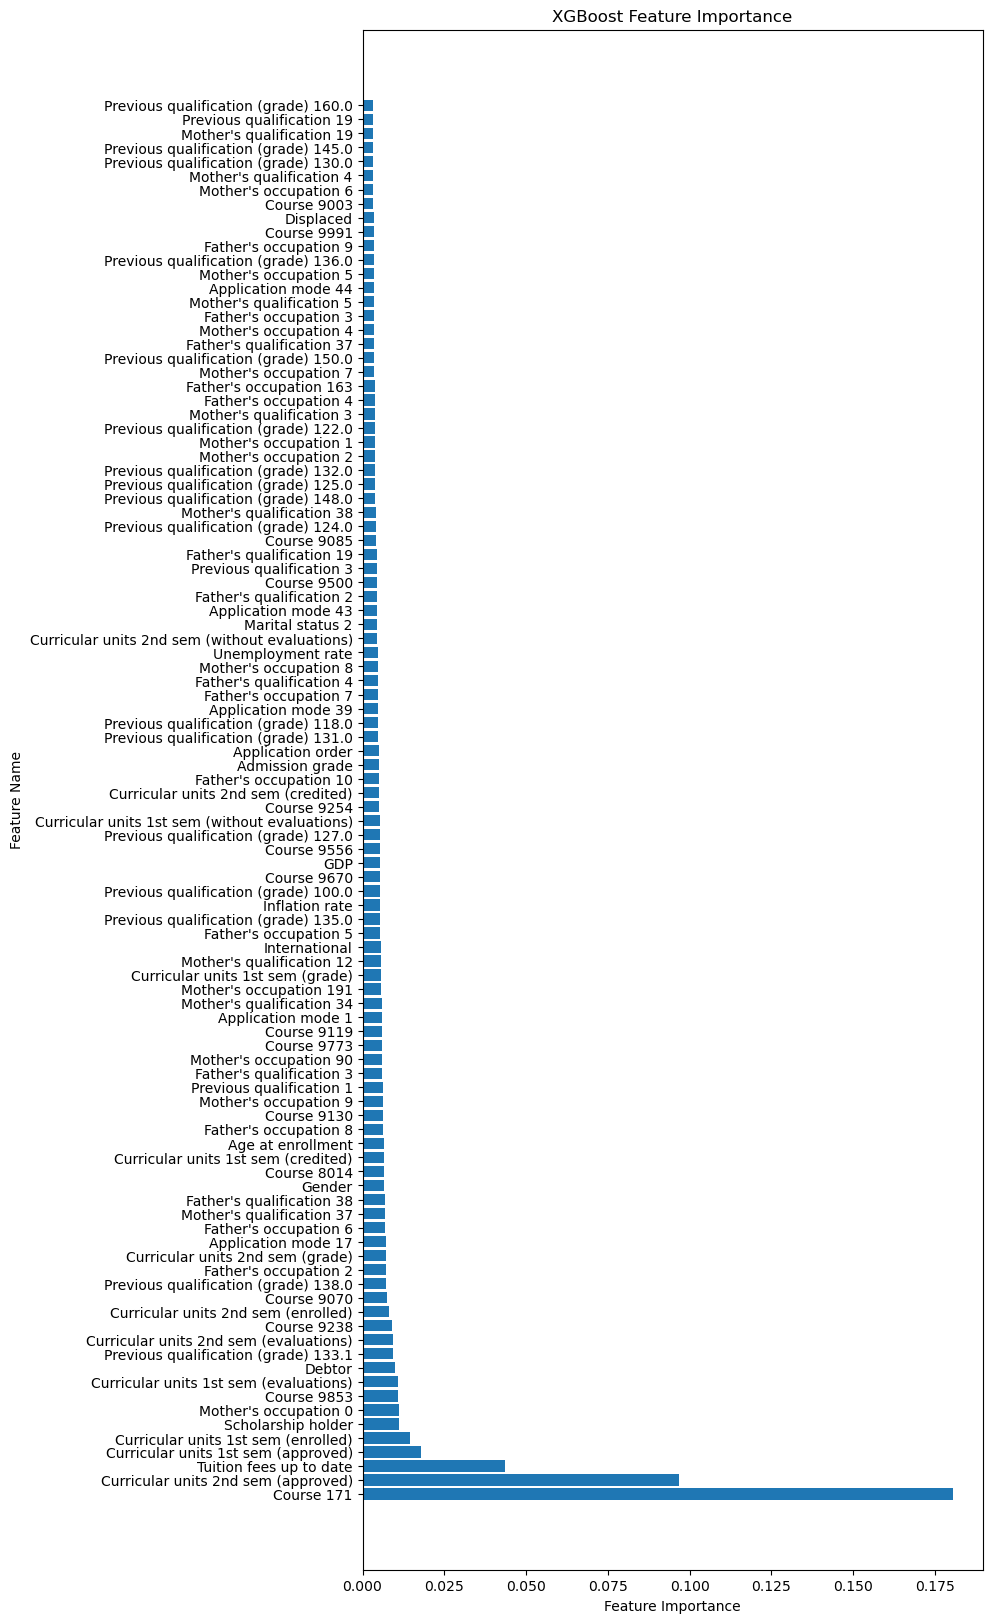

In [19]:
res = pd.concat([pd.Series(X.columns), pd.Series(
    model.feature_importances_)], axis=1)
res.columns = ['Feature', 'Importance']
res = res.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 20))
plt.barh(res['Feature'].head(100), res['Importance'].head(100))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('XGBoost Feature Importance')
plt.show()

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = XGBClassifier(best_params[0], best_params[1], best_params[2])
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print(get_metrics([
    ('train', Y_train, Y_train_pred),
    ('test', Y_test, Y_test_pred)
]))

/home/jakub/miniconda3/envs/tf_new/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


       accuracy        f1    recall precision
train  0.995479  0.995477  0.995479  0.995506
test   0.787571  0.786203  0.787571  0.790453


# Neural networks

In [21]:
mulY = pd.get_dummies(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, mulY, test_size=0.3)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, X_val: {X_val.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}, Y_val: {Y_val.shape}')

X_train: (3096, 347), X_test: (664, 347), X_val: (664, 347), Y_train: (3096, 3), Y_test: (664, 3), Y_val: (664, 3)


In [22]:
def build_and_train_model(layer_sizes: list, activation, optimizer, loss, dropout, batch_size, epochs, early_stopping = None, class_weights = None):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for i in layer_sizes:
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Dense(i, activation=activation))
    model.add(Dense(len(set(Y_train)), activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, class_weight=class_weights,
              callbacks=([EarlyStopping(monitor='val_accuracy', patience=early_stopping, restore_best_weights=True)] if early_stopping is not None else []), verbose=0)
    return model, history

### Example

In [23]:
model, history = build_and_train_model([128, 16], 'relu', 'adam', 'categorical_crossentropy', 0.2, 32, 100, 10)

I0000 00:00:1743203975.828115  467225 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2086 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1743203978.175308  467699 service.cc:152] XLA service 0x748b1c00e2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743203978.175349  467699 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-29 00:19:38.231666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743203978.487244  467699 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743203980.703551  467699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
       accuracy        f1    recall precision
train  0.791667  0.773379  0.791667  0.800085
val     0.71988  0.693429   0.71988  0.690811
test   0.731928   0.69889  0.731928   0.70008


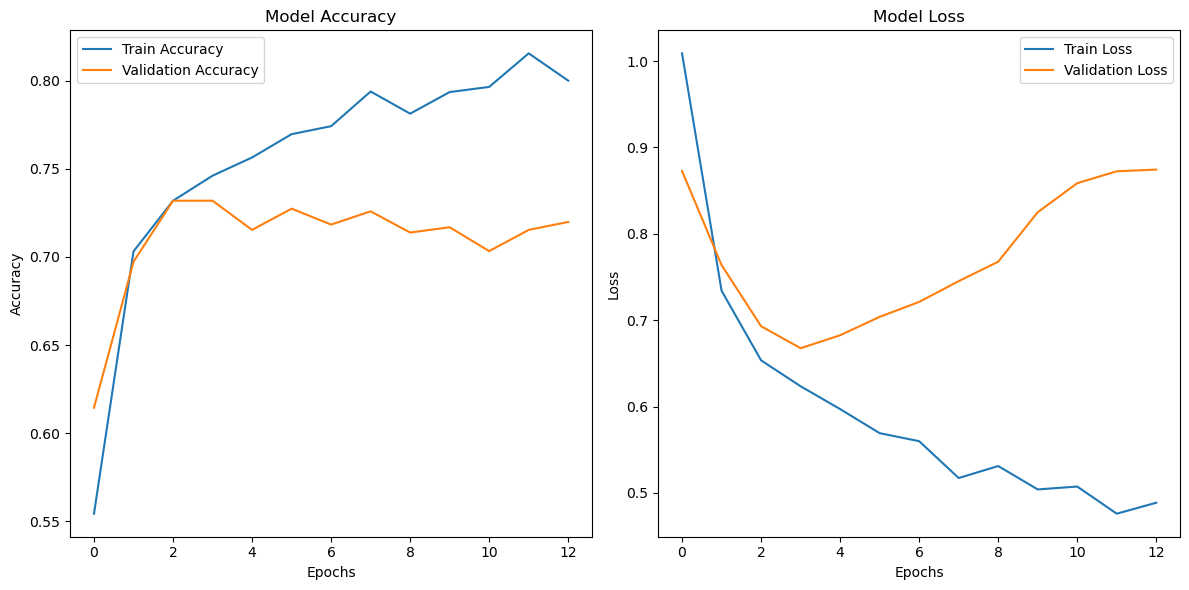

In [24]:
Y_train_pred = np.argmax(model.predict(X_train), axis=1)
Y_test_pred = np.argmax(model.predict(X_test), axis=1)
Y_val_pred = np.argmax(model.predict(X_val), axis=1)

Y_train_c = np.argmax(Y_train.values, axis=1)
Y_test_c = np.argmax(Y_test.values, axis=1)
Y_val_c = np.argmax(Y_val.values, axis=1)

print(get_metrics([
    ('train', Y_train_c, Y_train_pred),
    ('val', Y_val_c, Y_val_pred),
    ('test', Y_test_c, Y_test_pred)
]))

plot_history(history)

### Best layers

Neurons: [16], Train score: 0.7939276485788114, Val score: 0.7304216867469879
Neurons: [32], Train score: 0.8507751937984496, Val score: 0.7274096385542169
Neurons: [16, 16], Train score: 0.8020025839793282, Val score: 0.7379518072289156
Neurons: [32, 16], Train score: 0.7819767441860465, Val score: 0.7439759036144579
Neurons: [32, 32], Train score: 0.7968346253229974, Val score: 0.7575301204819277
Neurons: [64, 32, 16], Train score: 0.8155684754521964, Val score: 0.7394578313253012
Neurons: [128, 64, 32], Train score: 0.7997416020671835, Val score: 0.7575301204819277
Neurons: [256, 128, 64], Train score: 0.770671834625323, Val score: 0.7259036144578314


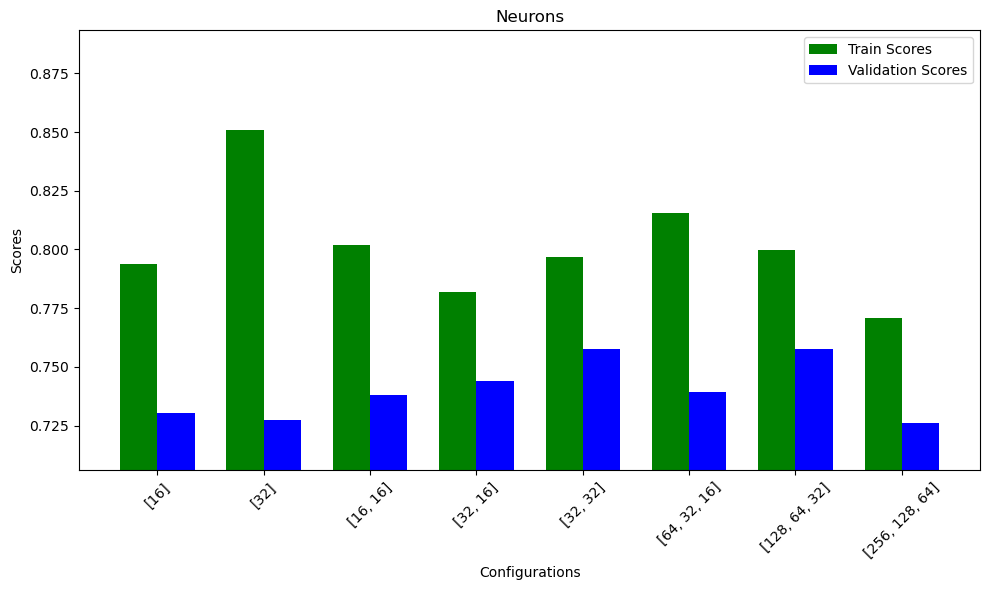

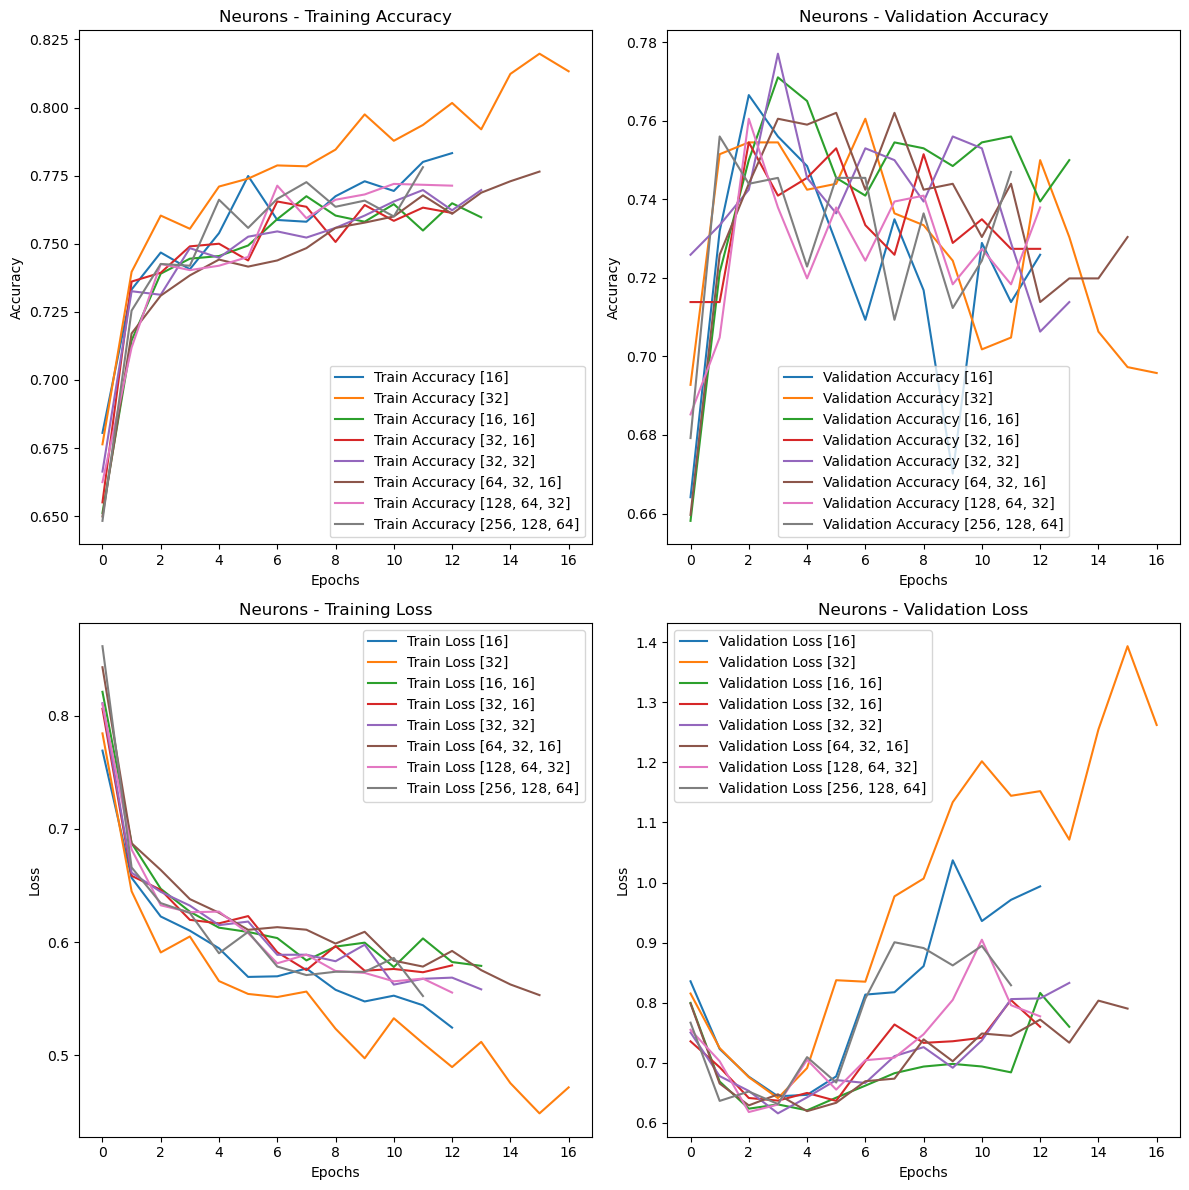

Best Neurons: [32, 32]


In [25]:
params = [
    [16],
    [32],
    [16, 16],
    [32, 16],
    [32, 32],
    [64, 32, 16],
    [128, 64, 32],
    [256, 128, 64]
]
title = 'Neurons'

best_score = None
best_neurons = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model(n, 'relu', Adam(
        0.01), 'categorical_crossentropy', 0.2, 32, 100, 10)

    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

    scores.append((train_score, val_score))
    histories.append(history)

    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_neurons = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_neurons}')

### Best dropout

Dropout: 0.1, Train score: 0.8281653746770026, Val score: 0.7048192771084337
Dropout: 0.2, Train score: 0.8055555555555556, Val score: 0.7454819277108434
Dropout: 0.3, Train score: 0.7819767441860465, Val score: 0.7439759036144579
Dropout: 0.4, Train score: 0.786498708010336, Val score: 0.766566265060241
Dropout: 0.5, Train score: 0.7906976744186046, Val score: 0.7379518072289156


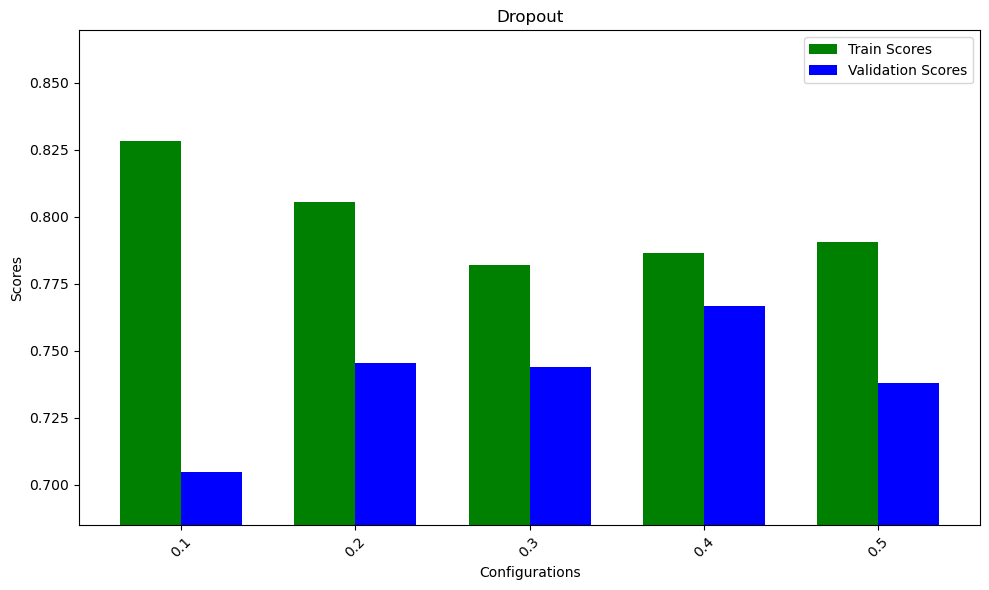

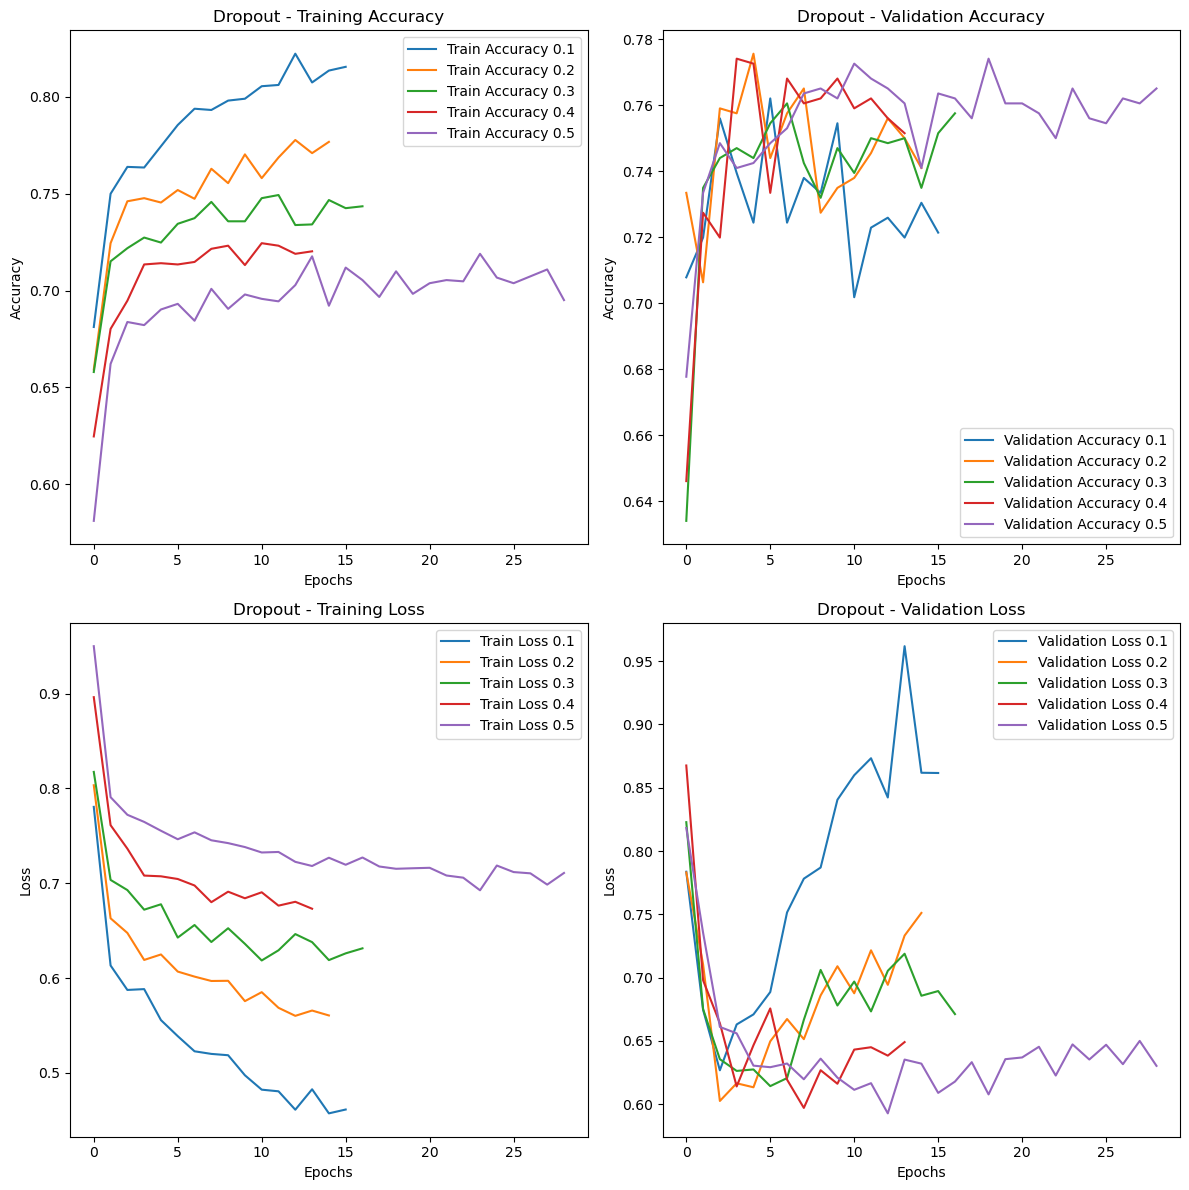

Best Dropout: 0.4


In [26]:
params = [0.1, 0.2, 0.3, 0.4, 0.5]
title = 'Dropout'

best_score = None
best_dropout = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model([32, 32], 'relu', Adam(
        0.01), 'categorical_crossentropy', n, 32, 100, 10)
    
    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))
    
    scores.append((train_score, val_score))
    histories.append(history)
    
    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_dropout = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_dropout}')

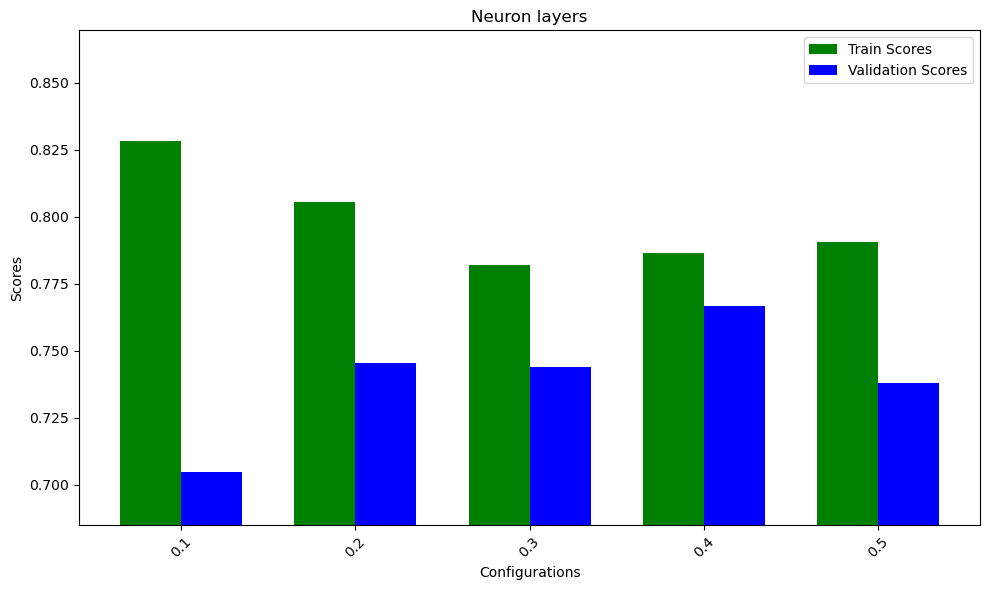

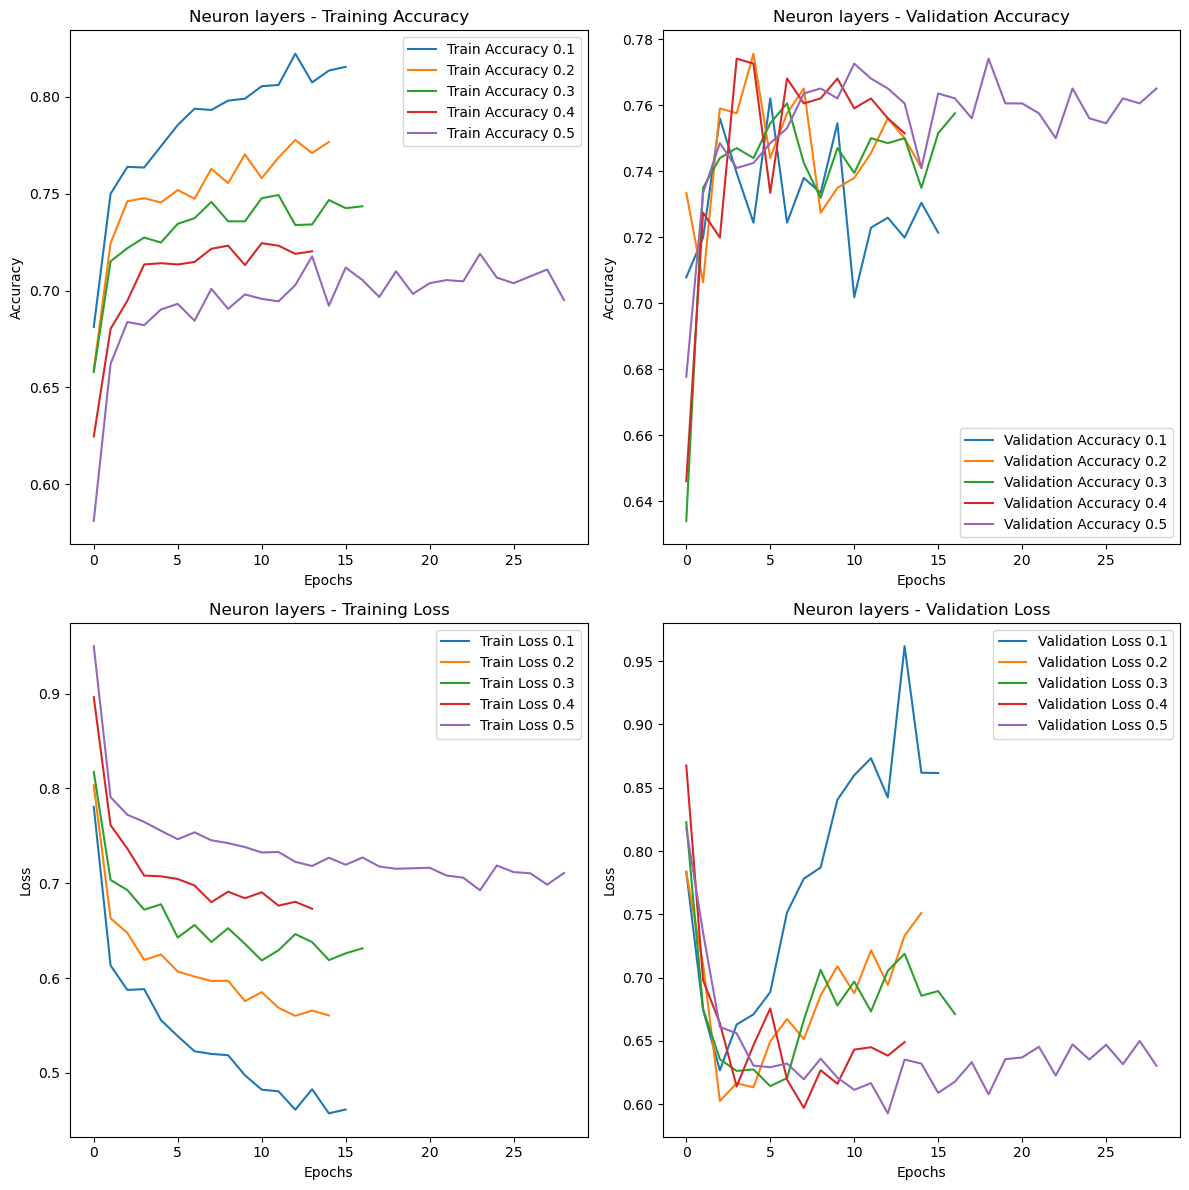

Best neurons: [32, 32]


In [27]:
plot_bar_params(params, scores, 'Neuron layers')
plot_multi_history(histories, params, 'Neuron layers')
print(f'Best neurons: {best_neurons}')

### Best activation

Activation: relu, Train score: 0.8107235142118863, Val score: 0.7424698795180723
Activation: elu, Train score: 0.8016795865633075, Val score: 0.7590361445783133
Activation: selu, Train score: 0.7845607235142119, Val score: 0.7364457831325302


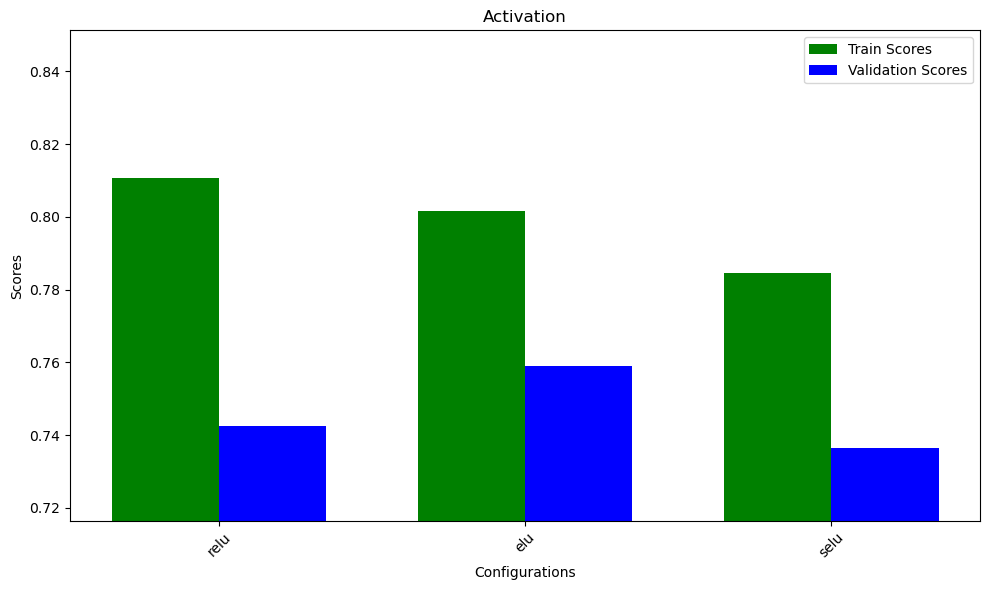

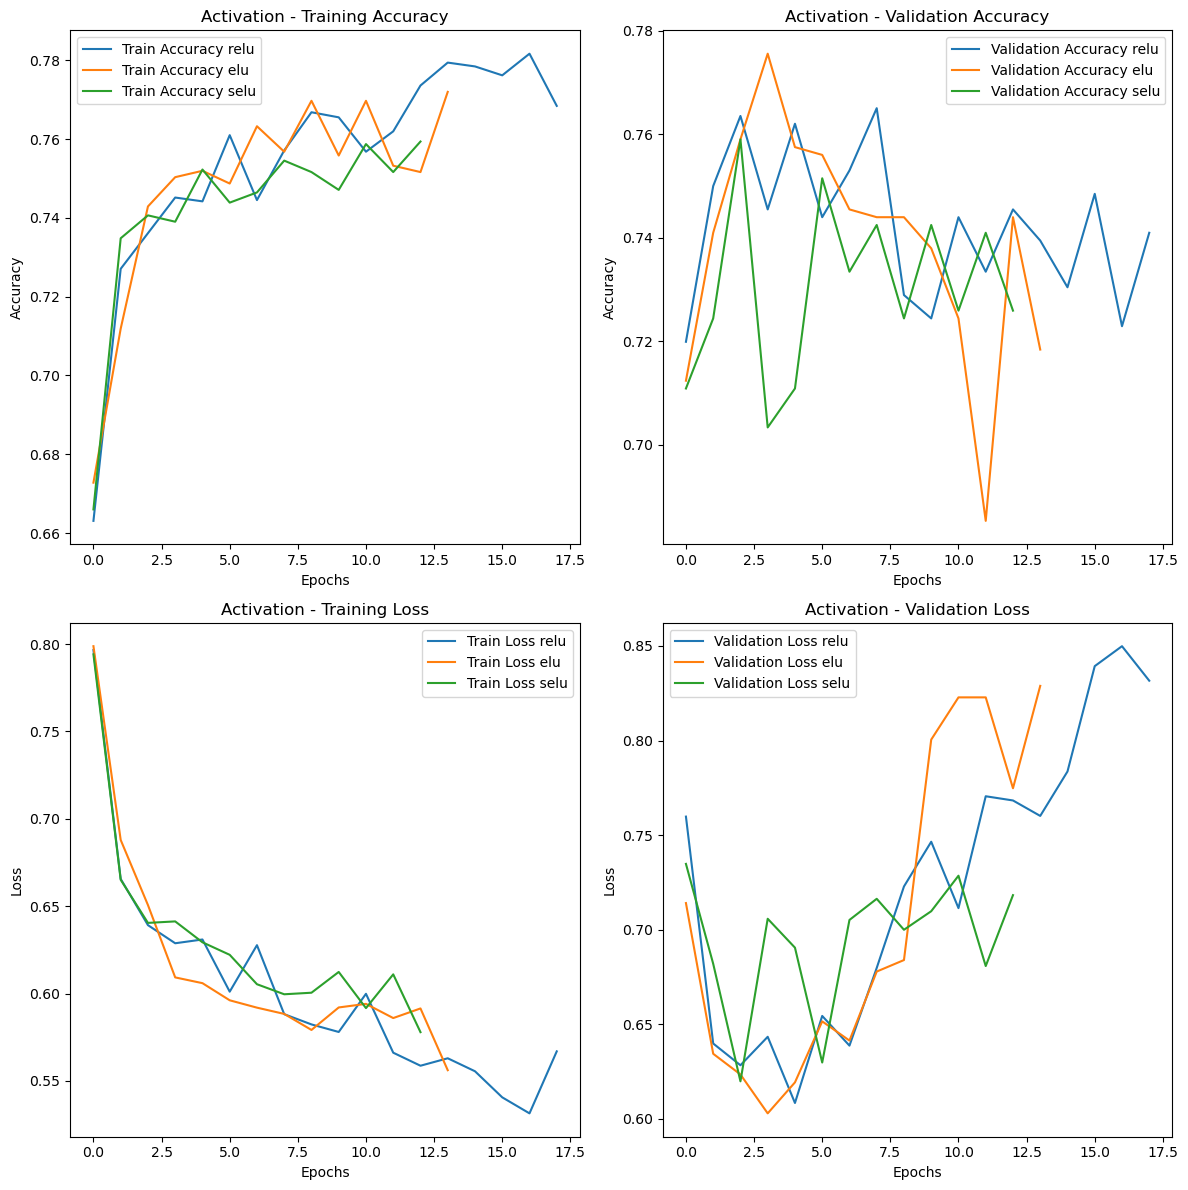

Best Activation: elu


In [28]:
params = ['relu', 'elu', 'selu']
title = 'Activation'

best_score = None
best_activation = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model([32, 32], n, Adam(
        0.01), 'categorical_crossentropy', 0.2, 32, 100, 10)

    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

    scores.append((train_score, val_score))
    histories.append(history)

    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_activation = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_activation}')

### Best batch size

Batch size: 16, Train score: 0.775516795865633, Val score: 0.7469879518072289
Batch size: 32, Train score: 0.8255813953488372, Val score: 0.7364457831325302
Batch size: 64, Train score: 0.8310723514211886, Val score: 0.733433734939759


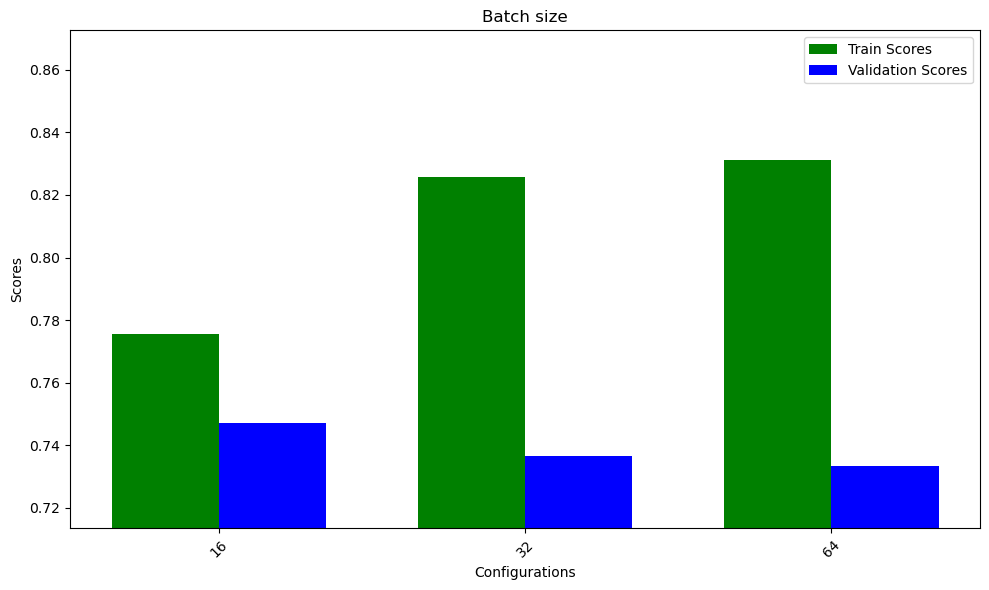

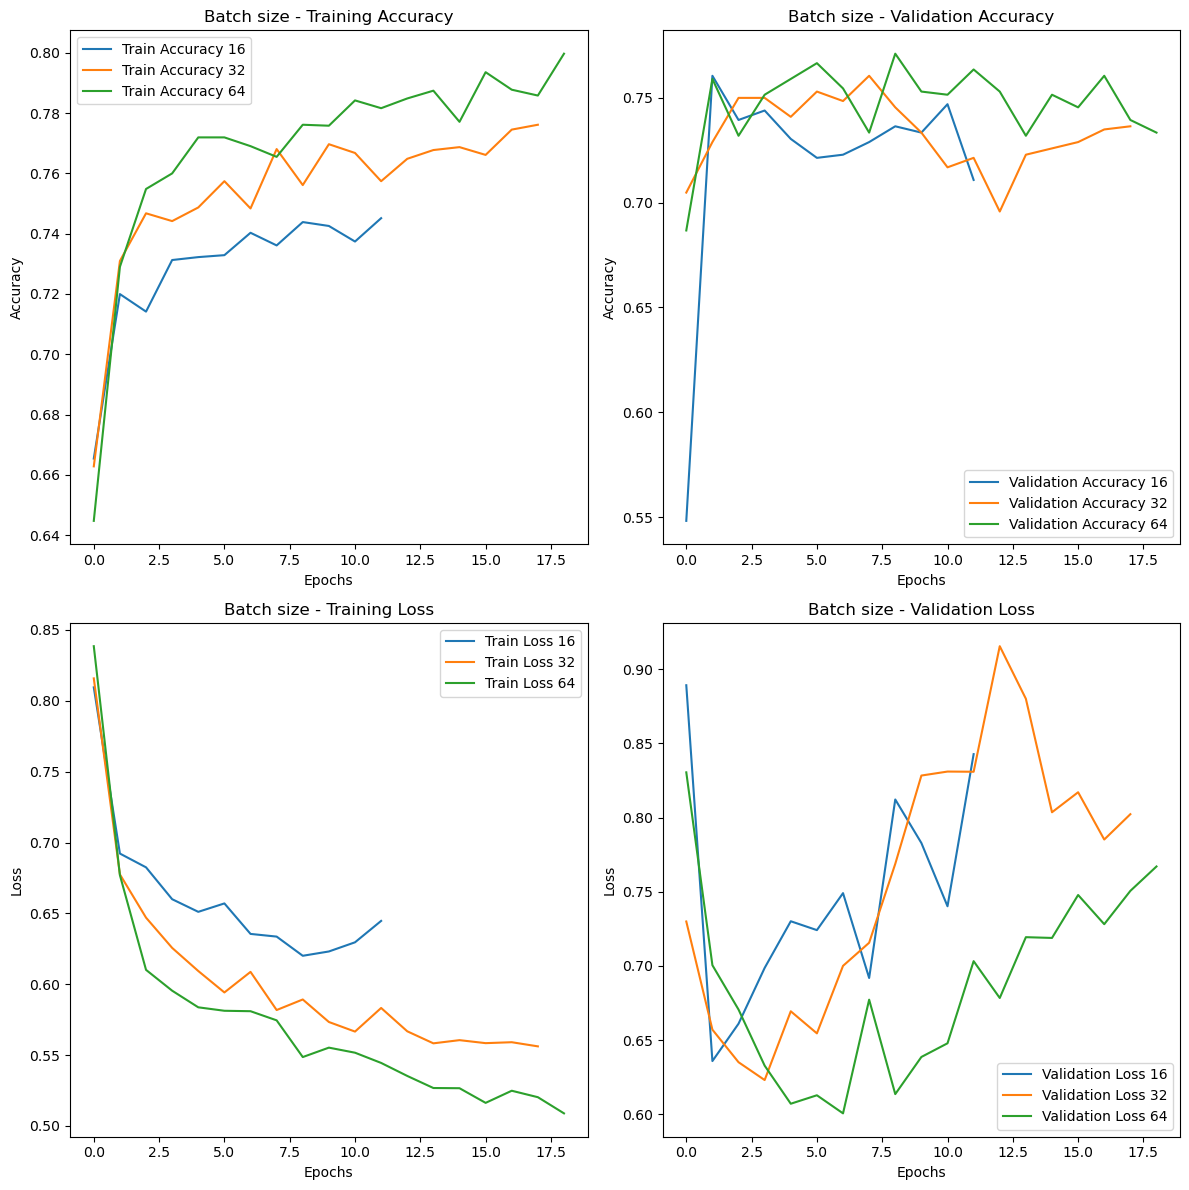

Best Batch size: 16


In [29]:
params = [16, 32, 64]
title = 'Batch size'

best_score = None
best_batch = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model([32, 32], 'relu', Adam(
        0.01), 'categorical_crossentropy', 0.2, n, 100, 10)

    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

    scores.append((train_score, val_score))
    histories.append(history)

    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_batch = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_batch}')

### Best optimizer

Optimizer: adam, Train score: 0.8330103359173127, Val score: 0.733433734939759
Optimizer: rmsprop, Train score: 0.8042635658914729, Val score: 0.7259036144578314
Optimizer: sgd, Train score: 0.8007105943152455, Val score: 0.7274096385542169


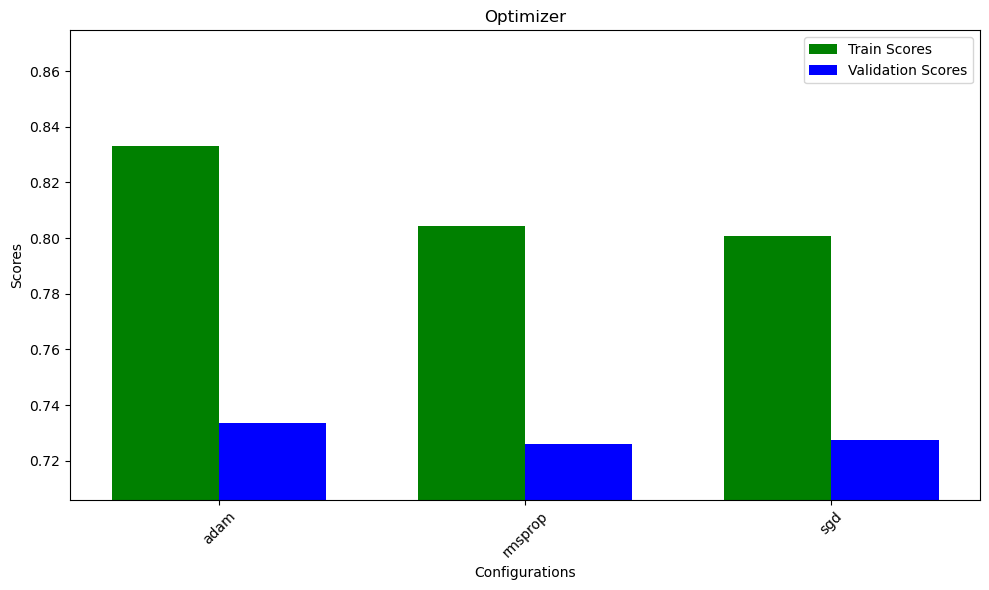

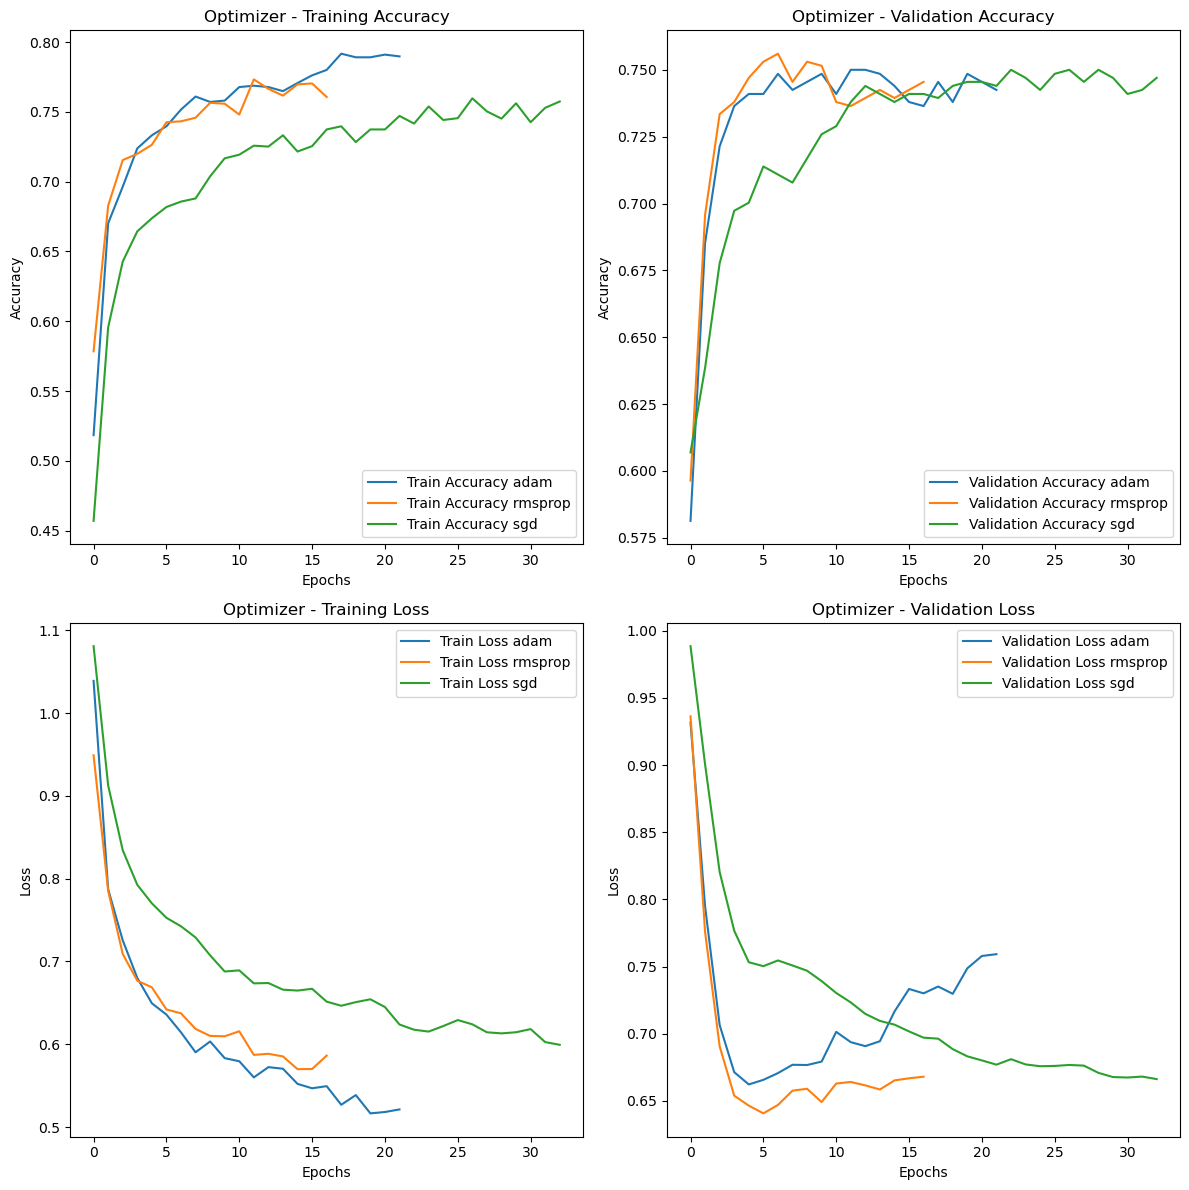

Best Optimizer: adam


In [30]:
params = ['adam', 'rmsprop', 'sgd']
title = 'Optimizer'

best_score = None
best_optimizer = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model([32, 32], 'relu', n, 'categorical_crossentropy', 0.2, 32, 100, 10)

    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

    scores.append((train_score, val_score))
    histories.append(history)

    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_optimizer = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_optimizer}')

### Best layers one more time

Neurons: [16, 16], Train score: 0.7806847545219638, Val score: 0.7289156626506024
Neurons: [32, 16], Train score: 0.7819767441860465, Val score: 0.7394578313253012
Neurons: [32, 32], Train score: 0.7793927648578811, Val score: 0.7349397590361446
Neurons: [16, 16, 16], Train score: 0.7848837209302325, Val score: 0.7349397590361446
Neurons: [32, 16, 8], Train score: 0.790374677002584, Val score: 0.7349397590361446
Neurons: [64, 32, 16], Train score: 0.7697028423772609, Val score: 0.7530120481927711
Neurons: [128, 16], Train score: 0.7228682170542635, Val score: 0.7078313253012049


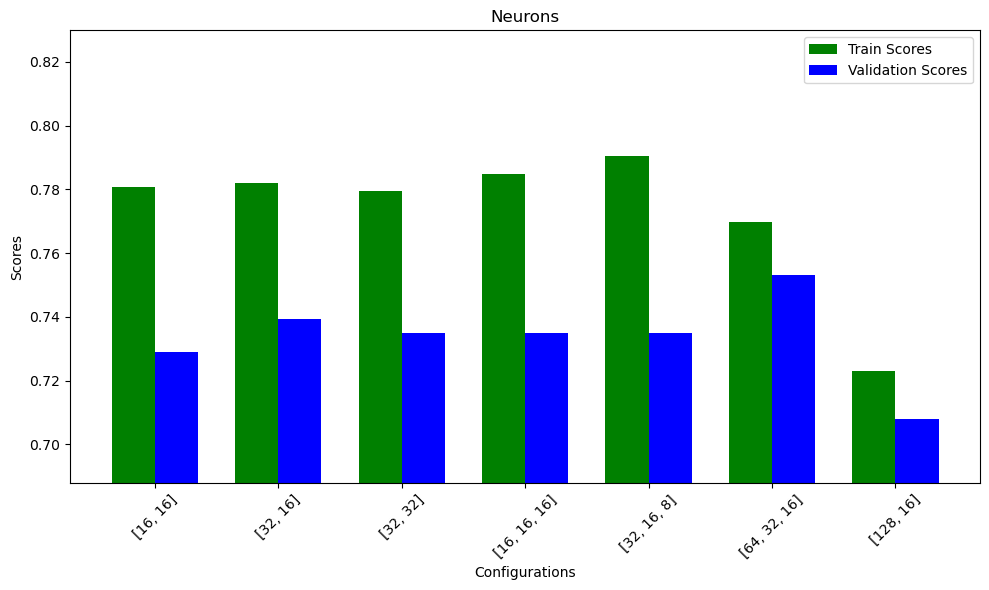

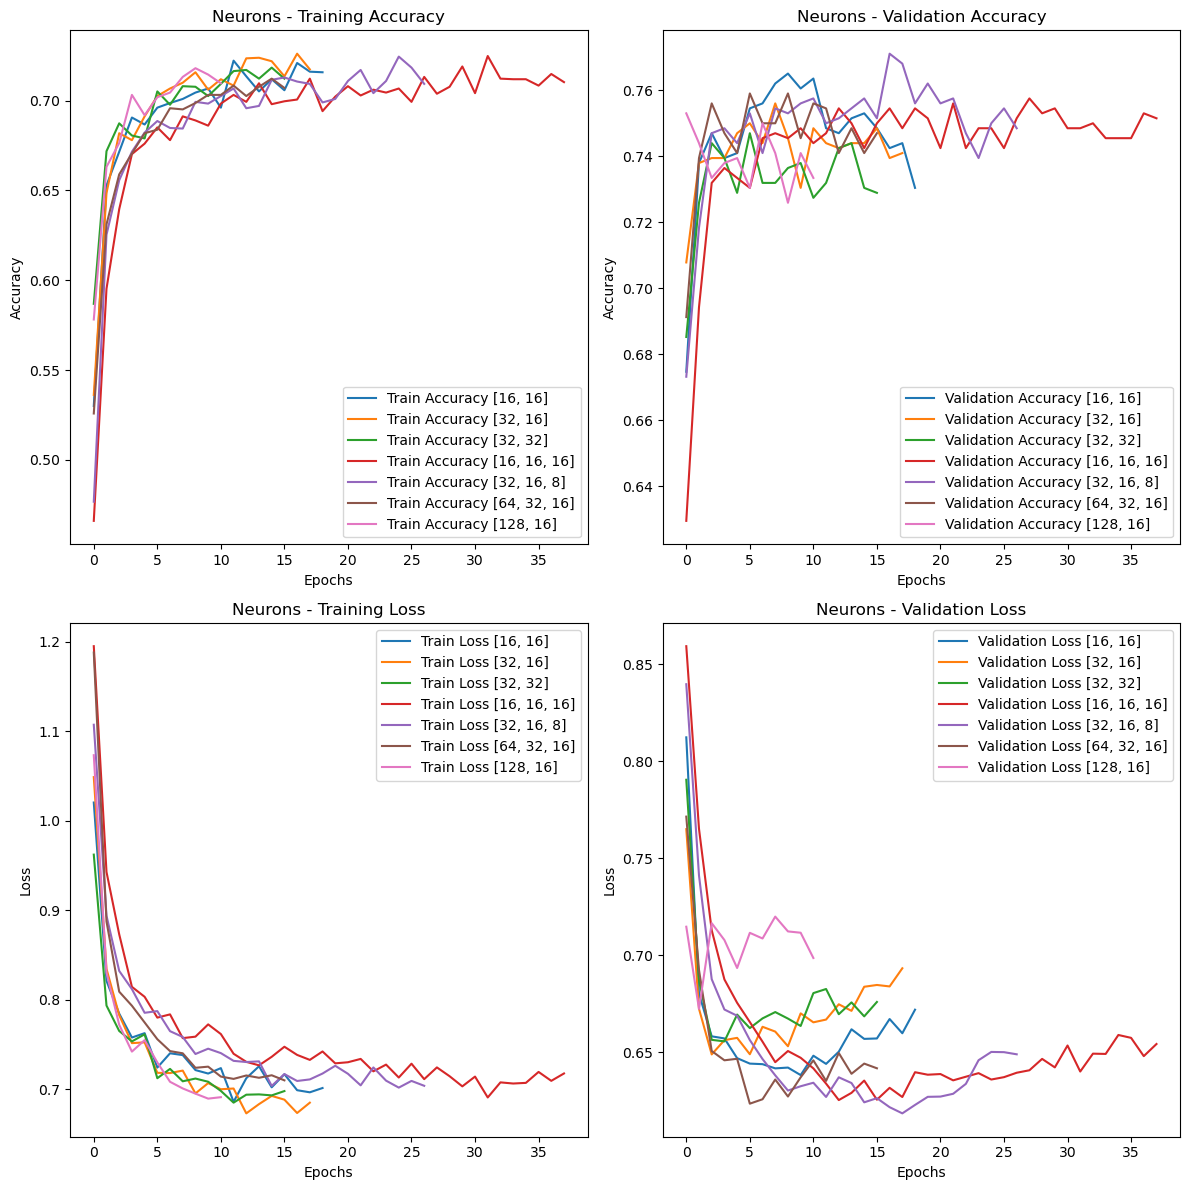

Best Neurons: [64, 32, 16]


In [31]:
params = [
    # [16],
    # [32],
    [16, 16],
    [32, 16],
    [32, 32],
    [16, 16, 16],
    [32, 16, 8],
    # [32, 32, 16],
    # [32, 32, 32],
    [64, 32, 16],
    [128, 16],
    # [128, 32],
    # [256, 16],
    # [256, 32],
    # [256, 64],
    # [128, 64, 32],
    # [256, 128, 64]
]
title = 'Neurons'

best_score = None
best_neurons = None
scores = []
histories = []
for n in params:
    model, history = build_and_train_model(n, best_activation, best_optimizer, 'categorical_crossentropy', best_dropout, best_batch, 100, 10)

    Y_train_pred = model.predict(X_train, verbose=0)
    Y_val_pred = model.predict(X_val, verbose=0)

    train_score = accuracy_score(
        np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1))
    val_score = accuracy_score(
        np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

    scores.append((train_score, val_score))
    histories.append(history)

    print(f'{title}: {n}, Train score: {train_score}, Val score: {val_score}')
    if best_score is None or val_score > best_score:
        best_score = val_score
        best_neurons = n


plot_bar_params(params, scores, title)
plot_multi_history(histories, params, title)
print(f'Best {title}: {best_neurons}')

### Best model according to experiments

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


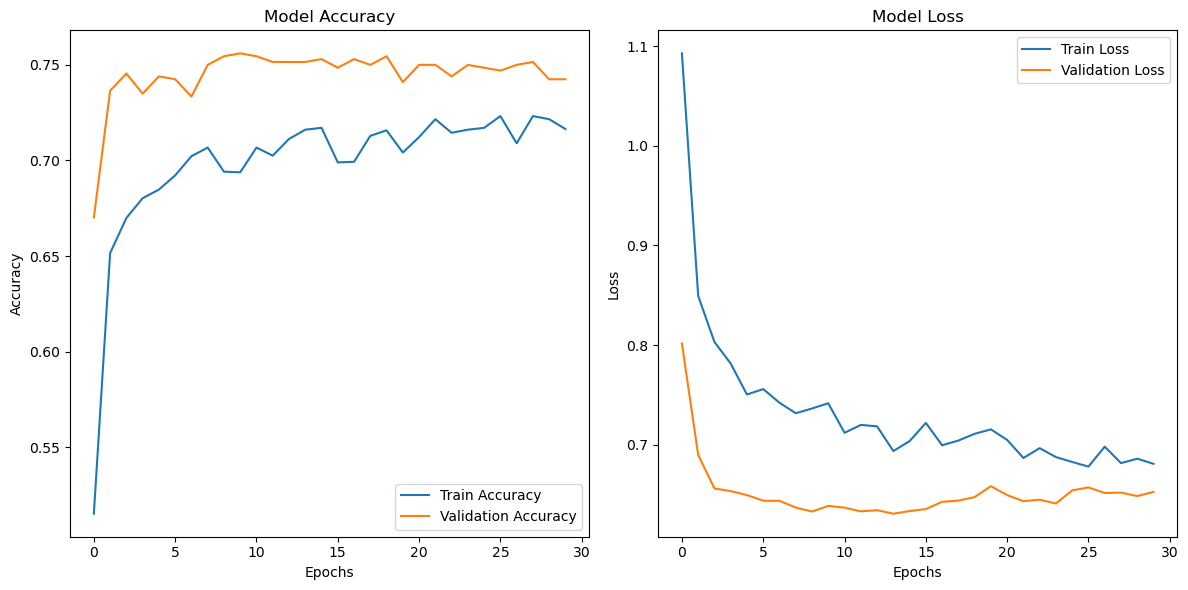


Neurons: [64, 32, 16], 
Activation: elu, 
Optimizer: adam, 
Dropout: 0.4, 
Batch: 16

       accuracy        f1    recall precision
train  0.786176  0.761165  0.786176  0.781662
val    0.707831  0.671694  0.707831  0.664156
test   0.756024  0.725869  0.756024  0.730034


In [32]:
model, history = build_and_train_model(best_neurons, best_activation, best_optimizer, 'categorical_crossentropy', best_dropout, best_batch, 100, 20)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

plot_history(history)

print(
    f'''
Neurons: {best_neurons}, 
Activation: {best_activation}, 
Optimizer: {best_optimizer}, 
Dropout: {best_dropout}, 
Batch: {best_batch}
''')
print(get_metrics([
    ('train', np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1)),
    ('val', np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1)),
    ('test', np.argmax(Y_test, axis=1), np.argmax(Y_test_pred, axis=1))
]))

### Trying rebalancing classes

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


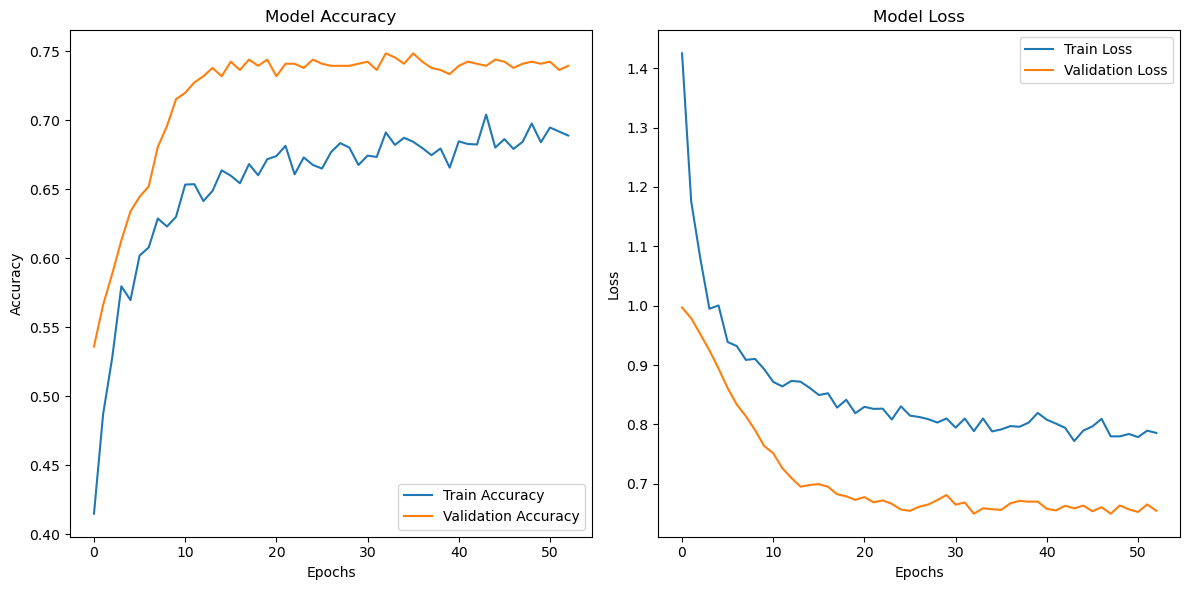

       accuracy        f1    recall precision
train  0.773902  0.775023  0.773902  0.784606
val    0.730422  0.732655  0.730422  0.740964
test   0.748494  0.751753  0.748494  0.765968


In [33]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([1, 0, 2]), y=np.argmax(Y_train, axis=1))
class_weights = dict(enumerate(class_weights))

model, history = build_and_train_model(
    [32, 32], 'elu', 'rmsprop', 'categorical_crossentropy', 0.5, 128, 100, 20, class_weights=class_weights)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
Y_val_pred = model.predict(X_val)

plot_history(history)
print(get_metrics([
    ('train', np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1)),
    ('val', np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1)),
    ('test', np.argmax(Y_test, axis=1), np.argmax(Y_test_pred, axis=1))
]))

### Final model

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


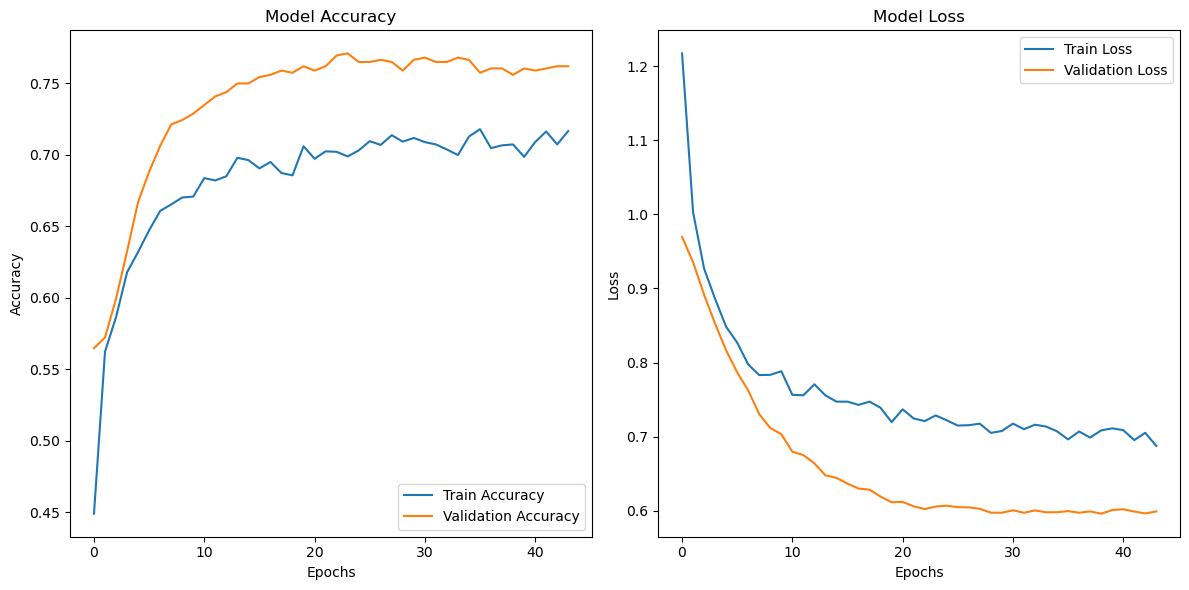

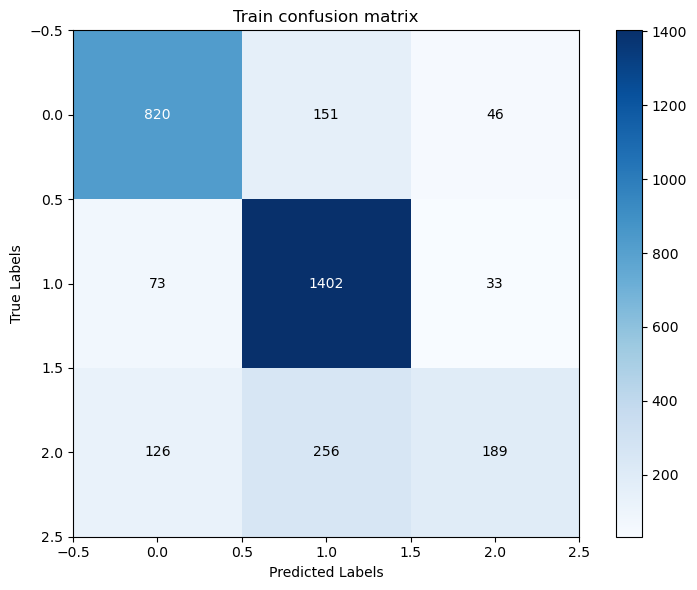

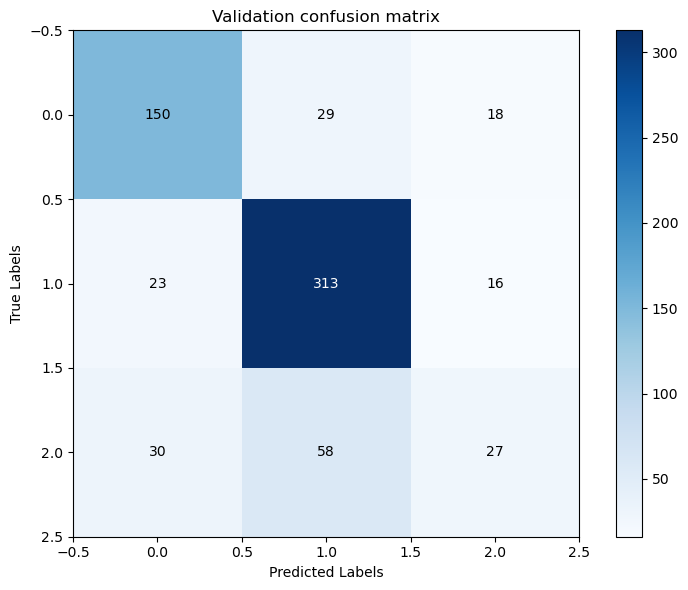

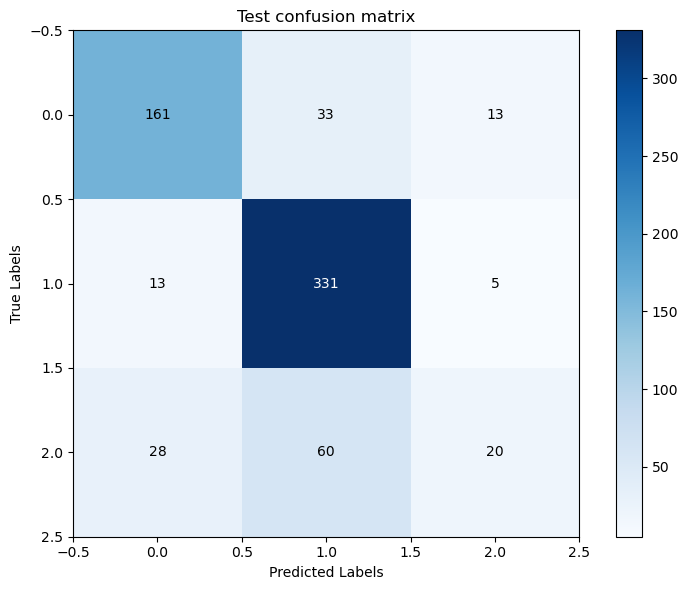

       accuracy        f1    recall precision
train  0.778747   0.75944  0.778747  0.771897
val    0.737952  0.716951  0.737952  0.710705
test   0.771084  0.740124  0.771084  0.744394


In [34]:
model, history = build_and_train_model(
    [32, 32], 'elu', 'rmsprop', 'categorical_crossentropy', 0.5, 128, 100, 20)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
Y_val_pred = model.predict(X_val)

plot_history(history)

plot_confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(
    Y_train_pred, axis=1), title='Train confusion matrix')
plot_confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(
    Y_val_pred, axis=1), title='Validation confusion matrix')
plot_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(
    Y_test_pred, axis=1), title='Test confusion matrix')

print(get_metrics([
    ('train', np.argmax(Y_train, axis=1), np.argmax(Y_train_pred, axis=1)),
    ('val', np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1)),
    ('test', np.argmax(Y_test, axis=1), np.argmax(Y_test_pred, axis=1))
]))

# Conclusions

Dataset appears to be very hard or just does not have enough data to cross 80% accuracy on test dataset. This example shows that sometimes it can be hard to create NN that would be better that XGBoost or RandomForest. During the excercise I tried different models like DecisionTree, RandomForest, XGBoost and many instances of NN, I also tried tuning hyperparameters. I observed how important different features are. I encountered problem with unbalanced classes but using class_weights did not help. Antoher problem I stumbled upon was columns with a lot of indexes representing something. I converted them using get_dummies but I got from 37 features to over 340 so I'm not sure if that's good solution to this problem. The highest accuracy I got was 77% on test dataset but this value varies from training to training. Tuning every hyperparameter separately allowed me to see how small changes influence the training process, what allowed me to fight with overfitting and instability of training process.